In [ ]:
!pip install pyro-ppl

In [ ]:

import torch
from torch import nn, optim
from torch.nn import KLDivLoss
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Categorical

import pyro
from pyro.infer import MCMC, HMC as pyro_hmc, NUTS as pyro_nuts

from tqdm.notebook import tqdm, trange
import numpy as np

import matplotlib.pyplot as plt


In [ ]:
# Target
class GaussianMixture:
    def __init__(self, dim, sigma, loc):
        self.g0 = MNormal(loc, sigma ** 2 * torch.eye(dim))
        self.g1 = MNormal(-loc, sigma ** 2 * torch.eye(dim))
        self.prob = 0.5
        self.dim = dim

    def sample(self, shape=(2,)):
        idx = torch.rand(shape) < self.prob
        samples = torch.zeros((*shape, self.dim))
        samples[idx, :] = self.g0.sample(shape)[idx, :]
        samples[~idx, :] = self.g1.sample(shape)[~idx, :]
        return samples

    def probability(self, x):
        return 0.5 * self.g0.log_prob(x).exp() + 0.5 * self.g1.log_prob(x).exp()

    def log_prob(self, x):
        return (0.5 * self.g0.log_prob(x).exp() + 0.5 * self.g1.log_prob(x).exp() + 1e-8).log()


# Proposal
class Cauchy:
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
        self.dim = len(self.loc)
        self.distr = torch.distributions.Cauchy(self.loc, self.scale)

    def probability(self, x):
        return self.distr.log_prob(z).mean(-1).log()

    def log_prob(self, z):
        log_target = self.distr.log_prob(z).sum(-1)#.mean(-1)
        return log_target

    def sample(self, n=(1,)):
        return self.distr.sample(n)

class Banana:
    def __init__(self, nu):
        self.nu = nu

    def probability(self, x):
        #print(x.size(1))
        even = np.arange(0, x.size(1), 2)
        odd = np.arange(1, x.size(1), 2)
        return torch.exp(torch.sum(-(x[..., odd] - x[..., even] ** 2) ** 2 / self.nu - (x[..., even] - 1) ** 2, dim=1))

    def log_prob(self, x):
        return torch.log(self.probability(x))

    def sample(self, dim, n_samples):
        X = np.random.randn(n_samples, dim)
        for idx in range(dim):
            if idx % 2 == 0:
                X[:, idx] += 1
            else:
                X[:, idx] *= np.sqrt(self.nu)
                X[:, idx] += X[:, idx - 1] ** 2
        return X

In [ ]:
def ISIR(start: torch.FloatTensor,
        target,
        proposal,
        n_samples: int,
        burn_in: int,
        *,
        n_particles: int,
        verbose: bool=False):
    """
    Iterated Sampling Importance Resampling

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        n_particles - number of particles including one from previous step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []

    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)
    n_chains, dim = x.size()
    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        logqs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        logps = torch.cat([logp_x[:, None], target.log_prob(particles.reshape(-1, dim)).reshape(n_chains, -1)], 1)
        #logps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = logps - logqs
        indices = Categorical(logits=log_weights).sample()

        x = particles[np.arange(x.shape[0]), indices]
        logp_x = logps[np.arange(x.shape[0]), indices]
        logq_x = logqs[np.arange(x.shape[0]), indices]

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [ ]:
from pyro.infer import HMC as pyro_hmc
from pyro.infer import MCMC
from pyro.infer import NUTS as pyro_nuts


def NUTS(start,
        target,
        n_samples: int,
        burn_in: int,
        *,
        verbose: bool = False) -> torch.FloatTensor:
    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_nuts(potential_fn=energy, full_mass=False)
    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true, _

In [ ]:
from torch.optim.lr_scheduler import StepLR


dim = 5

# define target
target = GaussianMixture(dim=dim, sigma=4.0, loc=3 * torch.ones(dim))
# define learnable parameters of proposal
#loc = nn.Parameter(torch.tensor([0., 0.]))
loc = nn.Parameter(torch.zeros(dim), requires_grad=True)
scale = nn.Parameter(torch.ones(dim), requires_grad=True)

# define params for chain
N_CHAINS = 50
N_SAMPLES = 1000
BURN_IN = 100

# kl divergence
criterion = KLDivLoss(log_target=True)
# optimizer
optimizer = optim.AdamW(lr=1e-4, params=(loc, scale))

In [ ]:
# MSC iteration
n_iter = 100
loss_arr = []
n_cis = 50
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=1-1e-4)


for i in tqdm(range(n_iter)):



    optimizer.zero_grad()

    # define proposal with new params
    proposal = Cauchy(scale=scale, loc=loc)


    # sample from it
    with torch.no_grad():
        chains, _ = ISIR(
        #target.sample((N_CHAINS,)),
        proposal.sample((N_CHAINS, )),
        target,
        proposal,
        N_SAMPLES,
        BURN_IN,
        n_particles=100)
        # функция тупая и не пашет с одной цепью
        #chain = chains[:, 0]

    #chains, _ = NUTS(
    #    proposal.sample((N_CHAINS,)),
    #    target,
    #    N_SAMPLES,
    #    BURN_IN,
    #)

    # get
    log_p = target.log_prob(chains)
    log_q = proposal.log_prob(chains)

    loss = (-1 * log_q).sum() #criterion(log_p, log_q)
    loss.backward()

    optimizer.step()


    scheduler.step()

    loss_arr.append(criterion(log_q, log_p).detach().item())

  0%|          | 0/100 [00:00<?, ?it/s]

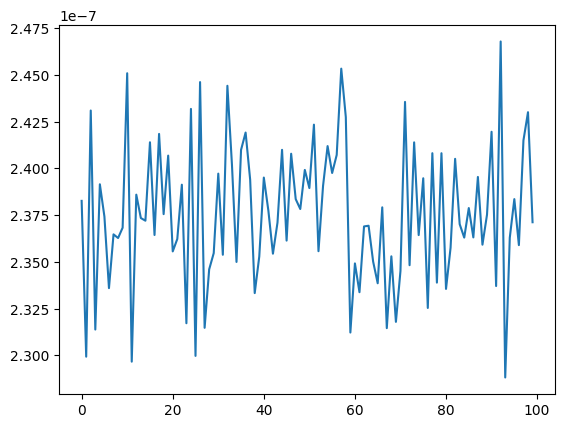

In [ ]:
plt.plot(loss_arr)

In [ ]:
criterion(log_q, log_p)

tensor(2.3712e-07, grad_fn=<MeanBackward0>)

In [ ]:
# Try with banana

dim = 8

# define target
target = Banana(nu=0.5)
# define learnable parameters of proposal
loc = nn.Parameter(torch.zeros(dim))
covariance_matrix = nn.Parameter(torch.eye(dim))

# define params for chain
N_CHAINS = 50
N_SAMPLES = 1000
BURN_IN = 100

# kl divergence
criterion = KLDivLoss(log_target=True)
# optimizer
optimizer = optim.AdamW(lr=1e-3, params=(loc, covariance_matrix))

In [ ]:
# MSC iteration
n_iter = 100
loss_arr = []

# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=1-1e-4)

for i in tqdm(range(n_iter)):
    # define proposal with new params
    #proposal = Cauchy(scale=scale, loc=loc)
    proposal = MNormal(loc=loc, covariance_matrix=covariance_matrix)
    # sample from it
    with torch.no_grad():
        chains, _ = ISIR(
        #target.sample((N_CHAINS,)),
        proposal.sample((N_CHAINS, )),
        target,
        proposal,
        N_SAMPLES,
        BURN_IN,
        n_particles=100)
        # функция тупая и не пашет с одной цепью
        chain = chains[:, 0]
    print('hui')
    print(chains.shape)
    optimizer.zero_grad()

    # get
    log_p = target.log_prob(chains)
    log_q = proposal.log_prob(chains)

    loss = criterion(log_p, log_q)
    loss.backward()

    optimizer.step()

    scheduler.step()

    loss_arr.append(loss.detach().item())

  0%|          | 0/100 [00:00<?, ?it/s]

hui
torch.Size([1000, 50, 8])


IndexError: index 9 is out of bounds for dimension 0 with size 8

In [ ]:
plt.plot(loss_arr)

In [ ]:
criterion(log_p, log_q)